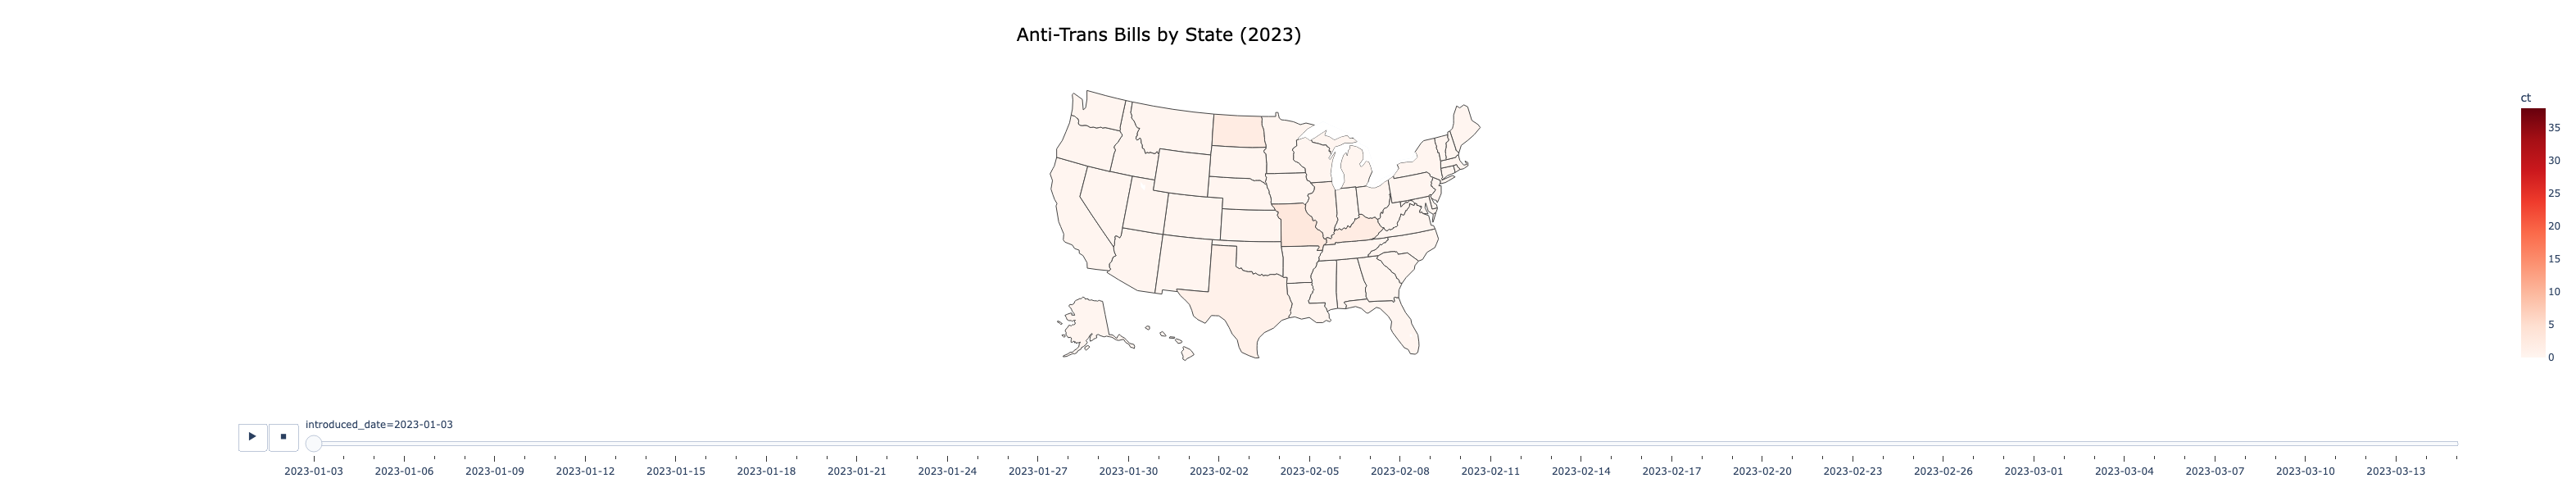

In [5]:
from datetime import datetime, timedelta
import math
import pandas as pd
import plotly.express as px

from lib.util import load_json

def make_date_range(date1, date2):
    return [
        date1 + timedelta(days=idx)
        for idx
        in range(0,(date2-date1).days + 1)
    ]
    
pd.set_option('display.max_rows', None)

aggregated = pd.read_json('../artifacts/aggregate.json')

geography = load_json('../datasets/geography.json')
states = geography['state_names'].keys()

aggregated = aggregated.loc[aggregated.introduced_date > '2023-01-01']
aggregated['introduced_date'] = aggregated['introduced_date'].transform(lambda x: datetime.strptime(x, '%Y-%m-%d').date())

min_date = aggregated['introduced_date'].min()
max_date = aggregated['introduced_date'].max()
all_dates = make_date_range(min_date, max_date)

all_states_all_dates = pd.DataFrame([
    { 'state': state, 'introduced_date': all_dates }
    for state
    in states
]).explode('introduced_date').reset_index().drop(['index'], axis=1)

joined = (
    all_states_all_dates
    .set_index(['state', 'introduced_date'])
    .join(aggregated.set_index(['state', 'introduced_date']))
)
joined['ct'] = joined['bill_id'].apply(lambda x: 0 if pd.isnull(x) else 1)

choropleth_data = (
    joined[['ct']]
    .reset_index()
    .groupby(by=['state', 'introduced_date'])
    .sum()
    .groupby(by='state')
    .cumsum()
    .reset_index()
)

fig = px.choropleth(
    choropleth_data,
    locations = 'state',
    color="ct", 
    animation_frame="introduced_date",
    color_continuous_scale="reds",
    locationmode='USA-states',
    scope="usa",
    range_color=(0, choropleth_data['ct'].max()),
    title='Anti-Trans Bills by State',
    height=600
)

fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 50
fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 5

fig.update_layout(
    height=600,
    width=1000,
    title_text = 'Anti-Trans Bills by State (2023)',
    title_font_size = 22,
    title_font_color="black", 
    title_x=0.45, 
)

fig.show()